### Imports

In [5]:
pip install scikeras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import json
import tensorflow as tf
import keras as kr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

### Constants

In [7]:
IMG_HEIGHT = 28
IMG_WIDTH = 28

LABELS = [
    "T-Shirt/Top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Boot"
]

BIN_LABELS = [
    "Clothing",
    "Footwear & Bags"
]

N_BIN_CLASSES = len(BIN_LABELS) - 1

WEIGHTS_FILENAME = "models/best_binary_model.weights.h5"
HYPERPARAMS_FILENAME = "models/best_binary_model.hyperparams.json"

In [8]:
IS_TO_FIND_BEST_HYPERPARAMS = True
IS_TO_TRAIN = True
IS_TO_REPLICATE = True

In [9]:
SEED = None if IS_TO_TRAIN else 12345
MAX_EPOCHS = 50

### Callback functions

In [10]:
# Callbacks
BEST_MODEL_CHECKPOINT = kr.callbacks.ModelCheckpoint(
    filepath=WEIGHTS_FILENAME,
    monitor='val_loss',
    mode='min',
    save_weights_only=True,
    save_best_only=True
)

EARLY_STOPPING = kr.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10
)

## Data Loading and Preprocessing

Next, the Fashion MNIST dataset will be loaded and prepared for training:
1. Load the dataset using Keras
2. Normalize the pixel values to the range [0,1]
3. Split the training data to create a validation set (80% training, 20% validation)

In [11]:
# Load dataset FASHION_MNIST
dataset = kr.datasets.fashion_mnist
(x_train_full, y_train_full), (x_test, y_test) = dataset.load_data()

# Split threshold definition
SPLIT = x_train_full.shape[0] * 8 // 10

# Normalize data and spit into training and validation
x_train = x_train_full[:SPLIT, :] / 255.
x_val = x_train_full[SPLIT:, :] / 255.
x_test = x_test / 255.

# Binarize and split labels into training and validation
y_train_full_bin = np.where(np.isin(y_train_full, [0, 1, 2, 3, 4, 6]), 0, 1)
y_train = y_train_full_bin[:SPLIT]
y_val = y_train_full_bin[SPLIT:]
y_test = np.where(np.isin(y_test, [0, 1, 2, 3, 4, 6]), 0, 1)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Dataset summary

In [12]:
# Output dataset information
print("Number of samples in the original training set: " + str(x_train_full.shape[0]))
print("Number of samples in the original test set: " + str(x_test.shape[0]))

print(f"\nDimensions of the training dataset: {x_train.shape[0]}. Does it correspond to 80%? {'Yes' if x_train.shape[0] == int(0.8 * x_train_full.shape[0]) else 'No'}")
print(f"Dimensions of the validation dataset: {x_val.shape[0]}. Does it correspond to 20%? {'Yes' if x_val.shape[0] == int(0.2 * x_train_full.shape[0]) else 'No'}")

# Validate if dataset is shuffled
is_shuffled = not np.array_equal(y_train_full, np.sort(y_train_full))
print(f"\nIs the dataset shuffled? {'Yes' if is_shuffled else 'No'}")

Number of samples in the original training set: 60000
Number of samples in the original test set: 10000

Dimensions of the training dataset: 48000. Does it correspond to 80%? Yes
Dimensions of the validation dataset: 12000. Does it correspond to 20%? Yes

Is the dataset shuffled? Yes


### Classes examples visualization

C:\Users\GONCA\AppData\Local\Temp\ipykernel_10636\3871020240.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


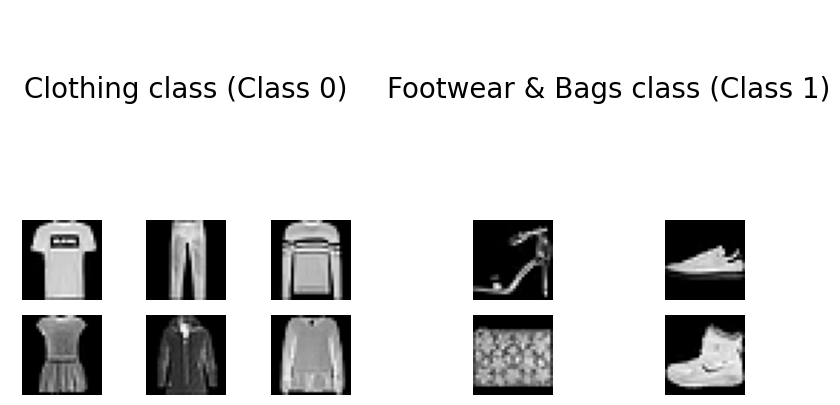

In [13]:
fig = plt.figure(figsize=(10, 5))
outer = gridspec.GridSpec(2, 2)

class_clothing_title_inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0])
class_footwear_bags_title_inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[1])

ax = plt.Subplot(fig, class_clothing_title_inner[0])
t = ax.text(0.5,0.5, 'Clothing class (Class 0)', fontsize=20)
t.set_ha('center')
ax.axis('off')
fig.add_subplot(ax)

ax = plt.Subplot(fig, class_footwear_bags_title_inner[0])
t = ax.text(0.5,0.5, 'Footwear & Bags class (Class 1)', fontsize=20)
t.set_ha('center')
ax.axis('off')
fig.add_subplot(ax)

class_clothing_inner = gridspec.GridSpecFromSubplotSpec(2, 3,
                subplot_spec=outer[2])

class_footwear_bags_inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                subplot_spec=outer[3])

inc = 0
for i, label in enumerate(LABELS):
    if i in [0, 1, 2, 3, 4, 6]:
        ax = plt.Subplot(fig, class_clothing_inner[inc])
        class_indices = np.where(y_train_full == i)[0]
        example_index = class_indices[0]
        ax.imshow(x_train_full[example_index], cmap='gray')
        ax.axis('off')
        fig.add_subplot(ax)
        inc += 1

inc = 0
for i, label in enumerate(LABELS):
    if i not in [0, 1, 2, 3, 4, 6]:
        ax = plt.Subplot(fig, class_footwear_bags_inner[inc])
        class_indices = np.where(y_train_full == i)[0]
        example_index = class_indices[0]
        ax.imshow(x_train_full[example_index], cmap='gray')
        ax.axis('off')
        fig.add_subplot(ax)
        inc += 1

fig.show()

## 4. Model Architecture

Simple neural network for binary classification:
1. Input layer for 28×28 grayscale images
2. Flatten layer to convert 2D images to 1D
3. Dense hidden layer with ReLU activation
4. Output layer with softmax activation for binary classification

In [14]:
# Network weight initialization
initializer = kr.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=SEED)

# Model definition
bin_fashion_model = kr.Sequential([
    kr.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT)),
    kr.layers.Flatten(),
    kr.layers.Dense((IMG_WIDTH * IMG_HEIGHT + N_BIN_CLASSES) * 2 // 3, activation='relu', kernel_initializer=initializer),
    kr.layers.Dense(N_BIN_CLASSES, activation='sigmoid', kernel_initializer=initializer)
], name="Fashion_MNIST_Binary_Model")

bin_fashion_model.summary()

Model: "Fashion_MNIST_Binary_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 523)            │       410,555 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           524 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,079 (1.57 MB)

 Trainable params: 411,079 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

Exploring the data to:
1. Find the best hyper parameters that maximize the model accuracy
2. From the best hyper parameters, store the best weights that maximize the accuracy and minimizes the loss
3. Save the best ANN model weights combination

In [18]:
if IS_TO_FIND_BEST_HYPERPARAMS:
    SEED = 12345
    # Function to create model, required for KerasClassifier
    def create_model(learning_rate):
        global bin_fashion_model

        bin_fashion_model.compile(
            loss='binary_crossentropy',
            optimizer=kr.optimizers.Adam(learning_rate=learning_rate),
            metrics=['accuracy']
        )

        return bin_fashion_model

    # Create the KerasClassifier
    model = KerasClassifier(model=create_model, verbose=0)

    # Define the grid search parameters
    param_grid = {
        'batch_size': [64, 128, 256, 512, 1024, 2048],
        'epochs': [MAX_EPOCHS],
        'model__learning_rate': np.linspace(0.0001, 0.1, 10)
    }

    # Create GridSearchCV
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=0)

    grid_result = grid.fit(x_train, y_train)

    best_params = grid_result.best_params_

    # Save the best parameters to a JSON file
    with open(HYPERPARAMS_FILENAME, 'w') as json_file:
        json.dump(grid_result.best_params_, json_file, indent=4)

    print(f"\n\n\nBest model hyper parameters: {json.dumps(grid_result.best_params_, indent=4)}")

else:
    with open(HYPERPARAMS_FILENAME, 'r') as json_file:
        best_params = json.load(json_file)
        print(f"Best model hyper parameters from file: {json.dumps(best_params, indent=4)}")

AttributeError: 'super' object has no attribute '__sklearn_tags__'

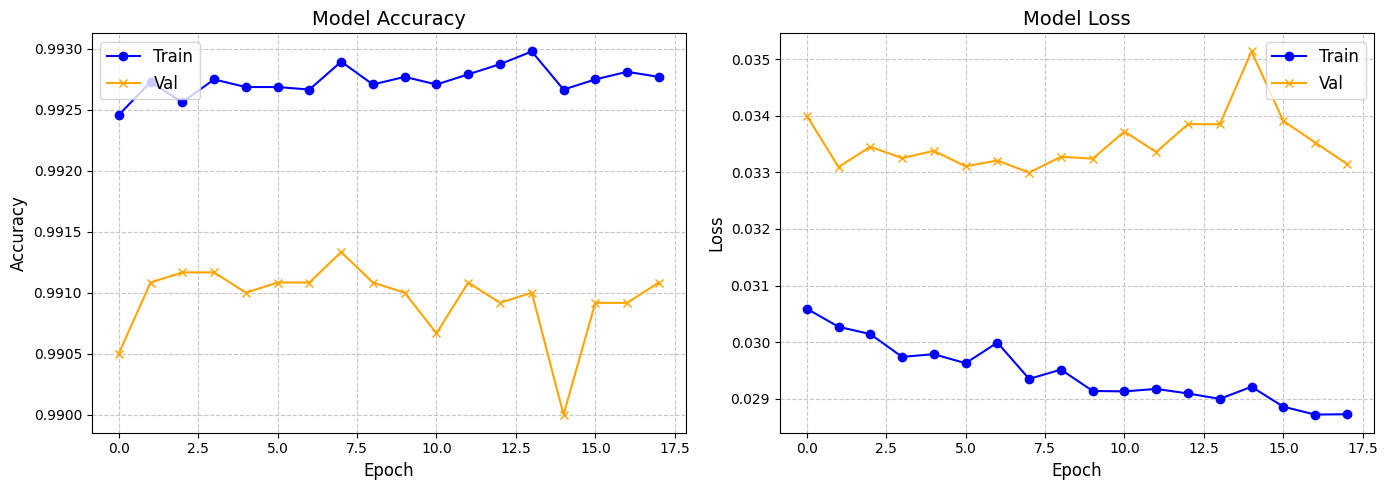

In [ ]:
if IS_TO_TRAIN:
    SEED = None
    bin_fashion_model.compile(
        loss="binary_crossentropy",
        optimizer=kr.optimizers.Adam(learning_rate=best_params["model__learning_rate"]),
        metrics=["accuracy"]
    )

    learning_hist = bin_fashion_model.fit(
        x_train,
        y_train,
        batch_size=best_params["batch_size"],
        epochs=MAX_EPOCHS,
        validation_data=(x_val, y_val),
        callbacks=[BEST_MODEL_CHECKPOINT, EARLY_STOPPING],
        verbose=0
    )

    # Plot training history
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    axs[0].plot(learning_hist.history['accuracy'], label='Train', color='blue', linestyle='-', marker='o')
    axs[0].plot(learning_hist.history['val_accuracy'], label='Val', color='orange', linestyle='-', marker='x')
    axs[0].set_title('Model Accuracy', fontsize=14)
    axs[0].set_ylabel('Accuracy', fontsize=12)
    axs[0].set_xlabel('Epoch', fontsize=12)
    axs[0].legend(loc='upper left', fontsize=12)
    axs[0].grid(True, linestyle='--', alpha=0.7)

    # Plot loss
    axs[1].plot(learning_hist.history['loss'], label='Train', color='blue', linestyle='-', marker='o')
    axs[1].plot(learning_hist.history['val_loss'], label='Val', color='orange', linestyle='-', marker='x')
    axs[1].set_title('Model Loss', fontsize=14)
    axs[1].set_ylabel('Loss', fontsize=12)
    axs[1].set_xlabel('Epoch', fontsize=12)
    axs[1].legend(loc='upper right', fontsize=12)
    axs[1].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [ ]:
if IS_TO_REPLICATE:
    bin_fashion_model.load_weights(WEIGHTS_FILENAME)

# Predict the test set
y_pred = bin_fashion_model.predict(x_test, verbose=0)

# Higher greater or equal to 0.5 the model predicts Footwear & Bags, lower than 0.5, Clothing is predicted
y_pred = np.where(y_pred >= 0.5, 1, 0)

# Evaluate the model
test_loss, test_acc = bin_fashion_model.evaluate(x_test, y_test, verbose=0)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate the precision and recall
recall = np.diag(cm) / np.sum(cm, axis=1)
precision = np.diag(cm) / np.sum(cm, axis=0)

## Model Evaluation

In [ ]:
results_table = pd.DataFrame({
    'Metric': ['Test Loss', 'Test Accuracy'],
    'Value': np.round([test_loss, test_acc], 4)
})

results_table

,Metric,Value
0,Test Loss,0.0368
1,Test Accuracy,0.9902


### Model recall and precision by label

In [ ]:
# Create a table to show each label's recall and precision
recall_precision_table = pd.DataFrame({
    'Label': BIN_LABELS,
    'Recall (%)': np.round(recall * 100, 1),
    'Precision (%)': np.round(precision * 100, 1)
})

recall_precision_table

,Label,Recall (%),Precision (%)
0,Clothing,99.2,99.1
1,Footwear & Bags,98.7,98.9


### Model confusion matrix

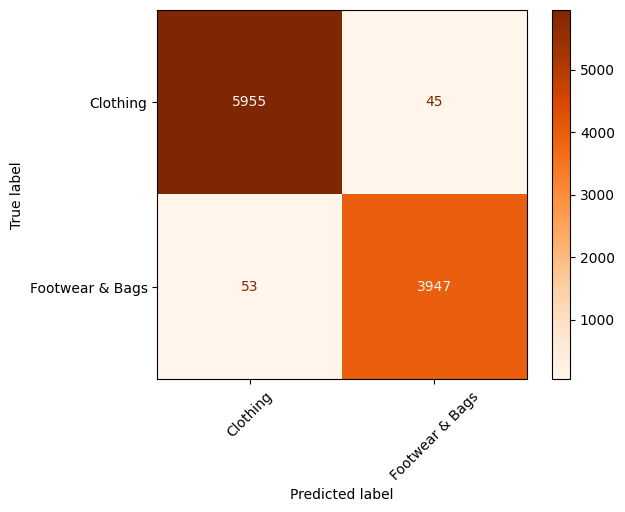

In [ ]:
# Plot the confusion matrix
ConfusionMatrixDisplay(cm, display_labels=["Clothing", "Footwear & Bags"]).plot(cmap=plt.colormaps['Oranges'], xticks_rotation=45)
plt.show()

## Confusion Matrix Analysis

Analyzing the confusion matrix, one can observe that the model learned with precision the differences between these two major groups. Only a few examples were misclassified, demonstrating that the model generalized very well the differences between these two classes. This high level of accuracy indicates that the model is effective in distinguishing between clothing and footwear & bags, making it a reliable tool for binary classification in this context.